### 全连接卷积神经网络（FCN）
> * FCN是用深度神经来做语义分割的奠基性工作
> * 它用转置卷积层来替换CNN最后的全连接层，从而实现每个像素的预测
![](../images/FCN.png)
> * 1x1卷积层不会改变空间信息，主要是降低维度，降低通道数，降低计算量
> * 转置卷积将图片还原成输入形状，转置卷积的通道数等价于类数，对每个像素的类别预测存在通道中

In [4]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import limutorch as d2l

In [5]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.0MB/s]


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [6]:
"""创建一个全卷积网络，它复制了ResNet-18大部分的预训练层，除了最后的全局平均汇聚层和最接近输出的全连接层"""
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [7]:
"""给定高度为320和宽度为480的输入，net的前向传播将输入的高和宽减小至原来的1/32，即10， 15"""
X = torch.rand(1, 3, 320, 480)
net(X).shape

torch.Size([1, 512, 10, 15])

In [8]:
"""使用1x1卷积层将输出通道数转换为数据集的类数21类。最后需要将特征图的高度和宽度增加到32倍，从而将其变回输入图像的高和宽。一般如果步幅为s，则填充为（s/2），卷积核大小为2s，转置卷积核会将输入的高和宽分别放大s倍。因为这里缩小了32倍，所以这里s为32"""
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes,kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                                    kernel_size=64, padding=16, stride=32))

In [9]:
"""初始化转置卷积层"""
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    print(filt)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))

    """
        weight[range(3), range[3], :, :] = X
        相当于weight[0, 0, :, :], weight[1, 1, :, :], weight[2, 2, :, :] = X
    """
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [10]:
"""双线性插值的上采样实验"""
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))

tensor([[0.0625, 0.1875, 0.1875, 0.0625],
        [0.1875, 0.5625, 0.5625, 0.1875],
        [0.1875, 0.5625, 0.5625, 0.1875],
        [0.0625, 0.1875, 0.1875, 0.0625]])


tensor([[[[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0

In [11]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('../images/catdog.png'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

input image shape: torch.Size([908, 1280, 3])
output image shape: torch.Size([1816, 2560, 3])


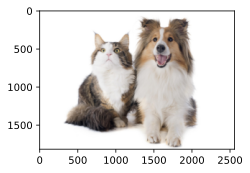

In [12]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0))
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img)

In [13]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W)

tensor([[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
        [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
        [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
        ...,
        [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
        [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
        [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]])


tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [14]:
"""读取数据集"""
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


read 1078 examples


loss 0.416, train acc 0.869, test acc 0.846
63.3 examples/sec on [device(type='cuda', index=0)]


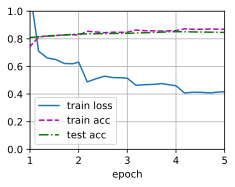

In [15]:
def loss (inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [56]:
"""预测"""
def predict(img):
  X = img.unsqueeze(0)
  pred = net(X.to(devices[0])).argmax(dim=1)
  return pred.reshape(pred.shape[1], pred.shape[2])

In [35]:
"""为了可视化预测的类别给每个像素，将预测的类别映射回它们在数据集中标注的颜色"""
def label2image(pred):
  colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
  X = pred.long()
  return colormap[X, :]

In [40]:
batch = next(iter(test_iter))
batch[0].shape,batch[1][1].unsqueeze(0).shape

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(torch.Size([32, 3, 320, 480]), torch.Size([1, 320, 480]))

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

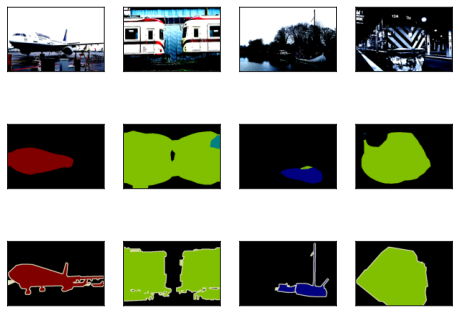

In [58]:
n, imgs = 4, []
for i in range(n):
  crop_rect = (0, 0, 320, 480)
  ## 这里不再重新读入test图片，直接使用之前加载test_iter，节省读写空间
  X = torchvision.transforms.functional.crop(test_iter.dataset.features[i], *crop_rect)
  pred = label2image(predict(X))
  imgs += [X.permute(1, 2, 0), pred.cpu(),
        torchvision.transforms.functional.crop(
            test_iter.dataset.labels[i], *crop_rect
        ).permute(1, 2, 0)    
       ]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2)